In [1]:
import tkinter as tk
from dragonfly import maximise_function, minimise_function
import socket
import struct
import numpy as np
import time
import re
from functions_hex_cam import *
import threading
import matplotlib.pyplot as plt
from matplotlib.backends.backend_tkagg import (FigureCanvasTkAgg, NavigationToolbar2Tk)
import sys 

udp_client = socket.socket(socket.AF_INET, socket.SOCK_DGRAM)
client = socket.socket(socket.AF_INET, socket.SOCK_STREAM)

C:\Users\loasis\AppData\Local\Programs\Python\Python37-32\lib\site-packages\dragonfly\utils\oper_utils.py:30: UserWarning: cannot import name 'direct' from 'dragonfly.utils.direct_fortran' (C:\Users\loasis\AppData\Local\Programs\Python\Python37-32\lib\site-packages\dragonfly\utils\direct_fortran\__init__.py)
Could not import Fortran direct library. Dragonfly can still be used, but might be slightly slower. To get rid of this warning, install a numpy compatible Fortran compiler (e.g. gfortran) and the python-dev package and reinstall Dragonfly.
  warn('%s\n%s'%(e, fortran_err_msg))


In [2]:
class GUI:    
    def __init__(self, master):
        
        self.fig,self.ax = plt.subplots(figsize=(5,3))
        self.ax.set_xlabel('Step Nr.')
        self.ax.set_ylabel('Quality')
        self.ax.axhline(30,color='tab:red')
        self.fig.tight_layout()
        
        #define global variables
        self.draw_counts = 0

        self.server_address_probecampost = ('192.168.15.24', 65280)
        self.server_address_probecampostnear = ('192.168.15.25', 65264)
        self.hexapod_address = ('192.168.15.16', 65529)

        self.subcriptionstring = b'Wait>>MeanCounts'
        self.SubcriptionCmdLength = len(self.subcriptionstring)
        self.sizepack = struct.pack('>i',self.SubcriptionCmdLength)

        self.subcriptionstring2 = b'Wait>>Centroidx,Centroidy'
        self.SubcriptionCmdLength2 = len(self.subcriptionstring2)
        self.sizepack2 = struct.pack('>i', self.SubcriptionCmdLength2)

        #define window
        self.master = master
        master.title('ML Capillary Alignment')
        master.geometry("550x550")
        master.option_add( "*font", "Calibri 10" )
        
        self.findsignalupdatemessage= tk.StringVar()
        self.findsignal_display = tk.Label(master, textvariable=self.findsignalupdatemessage, width=70, anchor='w',fg='red')
        self.findsignalupdatemessage.set(' ')
        self.findsignal_display.place(x=20,y=480)
        self.Findsignal = tk.Button(master, text="Find Beam",command=self.search_for_signal ,bg='red')
        self.Findsignal.place(x=20,y=500)
        
        self.prealignmentupdatemessage= tk.StringVar()
        self.message_display_pre = tk.Label(master, textvariable=self.prealignmentupdatemessage, width=70, anchor='w',fg='red')
        self.prealignmentupdatemessage.set(' ')
        self.message_display_pre.place(x=100,y=480)
        self.PreAlign = tk.Button(master, text="Pre-Alignment",command=self.optimise_coarse,bg='red')
        self.PreAlign.place(x=100,y=500)
        
        self.Align = tk.Button(master, text="Alignment",bg='red')
        self.Align.place(x=200,y=500)

        #Camera centroid input
        tk.Label(text='Starting Point', width=15).grid(row=0,column=1)
        tk.Label(text='Range', width=15).grid(row=0,column=2)
        tk.Label(text='Hex y: ', width=15).grid(row=1,column=0)
        tk.Label(text='Hex z: ', width=15).grid(row=2,column=0)
        tk.Label(text='Wangle: ', width=15).grid(row=3,column=0)
        tk.Label(text='Vangle: ', width=15).grid(row=4,column=0)

        hexy_prefill = self.get_current_hex_pos('ypos')
        hexz_prefill = self.get_current_hex_pos('zpos')
        hexw_prefill = self.get_current_hex_pos('wangle')
        hexv_prefill = self.get_current_hex_pos('vangle')

        self.e_hexy = tk.Entry(master)
        self.e_hexy.insert(0,hexy_prefill)
        self.e_hexy.grid(row=1, column=1)

        self.e_hexz = tk.Entry(master)
        self.e_hexz.insert(0,hexz_prefill)
        self.e_hexz.grid(row=2, column=1)

        self.e_wangle = tk.Entry(master)
        self.e_wangle.insert(0,hexw_prefill)
        self.e_wangle.grid(row=3, column=1)

        self.e_vangle = tk.Entry(master)
        self.e_vangle.insert(0,hexv_prefill)
        self.e_vangle.grid(row=4, column=1)

        self.e_hexy_r = tk.Entry(master)
        self.e_hexy_r.insert(0,0.2)
        self.e_hexy_r.grid(row=1, column=2)

        self.e_hexz_r = tk.Entry(master)
        self.e_hexz_r.insert(0,0.2)
        self.e_hexz_r.grid(row=2, column=2)

        self.e_wangle_r = tk.Entry(master)
        self.e_wangle_r.insert(0,0.15)
        self.e_wangle_r.grid(row=3, column=2)

        self.e_vangle_r = tk.Entry(master)
        self.e_vangle_r.insert(0,0.15)
        self.e_vangle_r.grid(row=4, column=2)

        tk.Label(text='N. Cam: ', width=15).grid(row=5,column=0)
        self.Ncamimg = tk.Entry(master)
        self.Ncamimg.insert(0,5)
        self.Ncamimg.grid(row=5, column=1)
        self.N = np.int(self.Ncamimg.get())

        tk.Label(text='Capital: ', width=15).grid(row=6,column=0)
        self.Capital = tk.Entry(master)
        self.Capital.insert(0,50)
        self.Capital.grid(row=6, column=1)

        tk.Label(text='Centroid x', width=15).grid(row=7,column=1)
        tk.Label(text='Centroid y', width=15).grid(row=7,column=2)

        tk.Label(text='Cam 1: ', width=15).grid(row=8,column=0)
        self.e_cen1x = tk.Entry(master)
        self.e_cen1x.insert(0,135.0)
        self.e_cen1x.grid(row=8, column=1)

        self.e_cen1y = tk.Entry(master)
        self.e_cen1y.insert(0,96.0)
        self.e_cen1y.grid(row=8, column=2)

        tk.Label(text='Cam 2: ', width=15).grid(row=9,column=0)
        self.e_cen2x = tk.Entry(master)
        self.e_cen2x.insert(0,716.7)
        self.e_cen2x.grid(row=9, column=1)

        self.e_cen2y = tk.Entry(master)
        self.e_cen2y.insert(0,586.7)
        self.e_cen2y.grid(row=9, column=2)

        self.centroidupdatemessage= tk.StringVar()
        self.message_display_cen = tk.Label(master, textvariable=self.centroidupdatemessage, width=70, anchor='w',fg='red')
        self.centroidupdatemessage.set(' ')
        self.message_display_cen.place(x=420,y=155)
        self.Initialise = tk.Button(master, text="Get Centroids",command=self.initialise_threading, bg='red')
        self.Initialise.place(x=420,y=175)
        
        tk.Label(text='Algorithm: ', width=15).grid(row=10,column=0)
        optimizeroptions = ['bo','rand','pdoo']
        self.optimizer_var = tk.StringVar()
        self.optimizer_var.set(optimizeroptions[0]) 
        self.drop_method = tk.OptionMenu(master, self.optimizer_var, *optimizeroptions).grid(row=10, column=1)

        #canvas
        tk.Label(text='Optimisation', width=15).grid(row=11,column=0,columnspan=2)
        self.myCanvas = FigureCanvasTkAgg(self.fig,master)
        self.myCanvas.draw()
        self.myCanvas.get_tk_widget().grid(row=12, column=1,columnspan=10)


        #Close GUI Button
        self.button_close = tk.Button(master, text="Close", command=master.destroy,bg='pink')
        self.button_close.place(x=420,y=500)

        self.var= tk.StringVar()
        self.message_display = tk.Label(master, textvariable=self.var, width=110, anchor='w')
        self.var.set('Messages:')
        self.message_display.place(x=0,y=530)
        
    def initialise(self):
        self.var.set('Messages: Getting centroids')
        self.centroidupdatemessage.set('In Progress')
        self.master.update()

        hexy_temp = self.get_current_hex_pos('ypos')
        hexz_temp = self.get_current_hex_pos('zpos')
        hexw_temp = self.get_current_hex_pos('wangle')
        hexv_temp = self.get_current_hex_pos('vangle')

        self.update_hex_pos(20.0,float(self.e_hexz.get()),float(self.e_wangle.get()),float(self.e_vangle.get()))

        cenx1,ceny1 = self.get_cam_centroid(self.server_address_probecampostnear)
        cenx2,ceny2 = self.get_cam_centroid(self.server_address_probecampost)    
        
        self.e_cen1x.delete(0,10)
        self.e_cen1y.delete(0,10)
        self.e_cen2x.delete(0,10)
        self.e_cen2y.delete(0,10)

        self.e_cen1x.insert(0,np.round(cenx1,1))
        self.e_cen1y.insert(0,np.round(ceny1,1))
        self.e_cen2x.insert(0,np.round(cenx2,1))
        self.e_cen2y.insert(0,np.round(ceny2,1))

        self.update_hex_pos(float(self.e_hexy.get()),float(self.e_hexz.get()),float(self.e_wangle.get()),float(self.e_vangle.get()))

        self.var.set('Messages: Done with centroids')
        self.centroidupdatemessage.set(' ')
        self.Initialise.configure(bg='green')
        self.master.update()
        
        return
    
    def update_hex_pos(self,hexy,hexz,wangle,vangle):
        udp_client = socket.socket(socket.AF_INET, socket.SOCK_DGRAM)

        hexy = np.round(hexy,4)
        hexz = np.round(hexz,4)
        wangle = np.round(wangle,4)
        vangle = np.round(vangle,4)
    
        hexycommand =bytes("setypos>>"+str(hexy),'ascii')
        #print(hexycommand)
        hexzcommand =bytes("setzpos>>"+str(hexz),'ascii')
        wanglecommand =bytes("setwangle>>"+str(wangle),'ascii')
        vanglecommand =bytes("setvangle>>"+str(vangle),'ascii')
    
        udp_client.sendto(hexycommand, self.hexapod_address)
        ypos_m = self.get_current_hex_pos('ypos')
        while np.abs(ypos_m-hexy) > 0.01:
            ypos_m = self.get_current_hex_pos('ypos')
        time.sleep(1)

        udp_client.sendto(hexzcommand, self.hexapod_address)
        zpos_m = self.get_current_hex_pos('zpos')
        while np.abs(zpos_m-hexz) > 0.1:
            zpos_m = self.get_current_hex_pos('zpos')
        time.sleep(1)
    
        udp_client.sendto(wanglecommand, self.hexapod_address)
        wpos_m = self.get_current_hex_pos('wangle')
        while np.abs(wpos_m-wangle) > 0.01:
            wpos_m = self.get_current_hex_pos('wangle')
        time.sleep(1) 
    
        udp_client.sendto(vanglecommand, self.hexapod_address)
        vpos_m = self.get_current_hex_pos('vangle')
        while np.abs(vpos_m-vangle) > 0.01:
            vpos_m = self.get_current_hex_pos('vangle') 
    
        return

    def get_cam_mean(self,cam_server_adress): #select camera
        client = socket.socket(socket.AF_INET, socket.SOCK_STREAM)
        client.connect(cam_server_adress)
        client.sendall(self.sizepack + self.subcriptionstring)
    
        #initialise loop
        counts = np.zeros(self.N)
        i = 0

        while i < self.N:
            size = struct.unpack('>i', client.recv(4))[0]  # Extract the msg size from four bytes - mind the encoding
            str_data = client.recv(size)

            data = re.findall(r'\d+', str_data.decode('ascii'))
            counts[i] = np.int(data[2])
            #print('Data size: %s Data value: %s' % (size, str_data.decode('ascii')))
            i = i+1
        client.close()

        meancounts_campost = np.mean(counts) 
        
        return meancounts_campost

    def get_cam_centroid(self,cam_server_adress): #select camera
        client = socket.socket(socket.AF_INET, socket.SOCK_STREAM)
        client.connect(cam_server_adress)
        client.sendall(self.sizepack2 + self.subcriptionstring2)
    
        #initialise loop
        centroid = np.zeros([self.N,2])
        i = 0

        while i < self.N:
            size = struct.unpack('>i', client.recv(4))[0]  # Extract the msg size from four bytes - mind the encoding
            str_data = client.recv(size)

            data = re.findall(r'\d+', str_data.decode('ascii'))
            #print(data)
            centroid[i,0] = np.int(data[2])
            centroid[i,1] = np.int(data[4])
            #print('Data size: %s Data value: %s' % (size, str_data.decode('ascii')))
            i = i+1
        client.close()

        cenx = np.mean(centroid[:,0]) 
        ceny = np.mean(centroid[:,1]) 

        return [cenx,ceny]
    
    def get_cam_exposure(self,cam_server_adress):
        client = socket.socket(socket.AF_INET, socket.SOCK_STREAM)
        client.connect(cam_server_adress)
        subcriptionstring = b'Wait>>exposure'
        SubcriptionCmdLength = len(subcriptionstring)
        sizepack = struct.pack('>i',SubcriptionCmdLength)
        client.sendall(sizepack + subcriptionstring)

        size = struct.unpack('>i', client.recv(4))[0]  # Extract the msg size from four bytes - mind the encoding
        str_data = client.recv(size)
        #print('Data size: %s Data value: %s' % (size, str_data.decode('ascii')))
        data = re.findall(r'\d+.\d+', str_data.decode('ascii'))
        exposure = float(data[0])
        client.close()
    
        return exposure
    
    def set_cam_exposure(self,cam_server_adress,exposure):
        udp_client = socket.socket(socket.AF_INET, socket.SOCK_DGRAM)
        changecamexposure =bytes("setexposure>>"+str(exposure),'ascii')
        udp_client.sendto(changecamexposure, cam_server_adress)
        
        return

    def get_current_hex_pos(self,parameter):
        client = socket.socket(socket.AF_INET, socket.SOCK_STREAM)
        client.connect(self.hexapod_address)

        subcriptionstring = bytes("Wait>>"+parameter,'ascii')
        SubcriptionCmdLength = len(subcriptionstring)
        sizepack = struct.pack('>i', SubcriptionCmdLength)

        client.sendall(sizepack + subcriptionstring)
        size = struct.unpack('>i', client.recv(4))[0]  # Extract the msg size from four bytes - mind the encoding
        str_data = client.recv(size)
        #print('Data size: %s Data value: %s' % (size, str_data.decode('ascii')))
        position = np.float(re.findall(r'[-+]?\d+\.\d+', str_data.decode('ascii'))[0])
        client.close()

        return position

    def opt_align(self,hexp):
        hexy = hexp[0]
        hexz = hexp[1]
        wangle = hexp[2]
        vangle = hexp[3]

        #update hexapod pos
        self.update_hex_pos(hexy,hexz,wangle,vangle)

        #get cam property
        meancounts_campost1 = self.get_cam_mean(self.server_address_probecampostnear)
        meancounts_campost2 = self.get_cam_mean(self.server_address_probecampost)

        meancounts_campost = meancounts_campost1+meancounts_campost2

        if meancounts_campost>30:
            cenx1,ceny1 = self.get_cam_centroid(self.server_address_probecampostnear)
            cenx2,ceny2 = self.get_cam_centroid(self.server_address_probecampost)

            #get centroids when cap is out from gui
            capout_cenx1 = float(self.e_cen1x.get())
            capout_ceny1 = float(self.e_cen1y.get())
            capout_cenx2 = float(self.e_cen2x.get())
            capout_ceny2 = float(self.e_cen2y.get())

            cen = 8*np.sqrt((np.abs(cenx1-capout_cenx1)+np.abs(ceny1-capout_ceny1))**2)+np.sqrt((np.abs(cenx2-capout_cenx2)+np.abs(ceny2-capout_ceny2))**2)
        else:
            cen=2000-meancounts_campost*2


        self.ax.scatter(self.draw_counts,np.round(cen),color='tab:blue',s=10)
        self.myCanvas.draw()
        self.master.update()
        
        self.draw_counts = self.draw_counts+1

        #print(np.round(cen))

        return cen

    def optimise_coarse(self):
        
        self.draw_counts = 0
        self.plot_canvas()
        self.ax.set_ylim(1,3000)
        self.ax.axhline(30,color='tab:red')
        self.ax.set_yscale('log')
        self.myCanvas.draw()
    
        #get measurement range from gui
        self.var.set('Messages: optimising')
        self.prealignmentupdatemessage.set('In progress')
        self.master.update()
    
        r_hexy = float(self.e_hexy.get())
        r_hexy_r = float(self.e_hexy_r.get())
        r_hexz = float(self.e_hexz.get())
        r_hexz_r = float(self.e_hexz_r.get())
        r_hexw = float(self.e_wangle.get())
        r_hexw_r = float(self.e_wangle_r.get())
        r_hexv = float(self.e_vangle.get())
        r_hexv_r = float(self.e_vangle_r.get())
                     
        domain = [[r_hexy-r_hexy_r,r_hexy+r_hexy_r],[r_hexz-r_hexz_r,r_hexz+r_hexz_r],[r_hexw-r_hexw_r,r_hexw+r_hexw_r],[r_hexv-r_hexv_r,r_hexv+r_hexv_r]]
        max_capital = self.Capital.get()
    
        max_val, max_pt, history = minimise_function(self.opt_align, domain, max_capital,opt_method=self.optimizer_var.get())
        #finsish set to optimum values
        print('We are done here:')
        print(max_val)
        print(max_pt)
        
        final_cen = self.opt_align(max_pt)
        
        self.e_hexy.delete(0,10)
        self.e_hexz.delete(0,10)
        self.e_wangle.delete(0,10)
        self.e_vangle.delete(0,10)
        
        self.e_hexy.insert(0,np.round(max_pt[0],4))
        self.e_hexz.insert(0,np.round(max_pt[1],4))
        self.e_wangle.insert(0,np.round(max_pt[2],4))
        self.e_vangle.insert(0,np.round(max_pt[3],4))
        
        self.prealignmentupdatemessage.set(' ')
        self.var.set('Messages: optimisation is done')
        self.PreAlign.configure(bg='green')
        self.ax.axhline(np.round(final_cen),color='tab:green')
        self.myCanvas.draw()
        self.master.update()
        return
    
    def initialise_threading(self):
        t =  threading.Thread(target=self.initialise) # Create thread
        t.start() # Start thread
        return
    
    def plot_canvas(self):
        self.ax.clear()
        self.ax.set_xlabel('Step Nr.')
        self.ax.set_ylabel('Quality')
        self.fig.tight_layout()
        
        self.myCanvas.draw()
        self.master.update()
        return
    
    def find_counts(self,hexp):
        hexy = hexp[0]
        hexz = hexp[1]
        wangle = hexp[2]
        vangle = hexp[3]

        #update hexapod pos
        self.update_hex_pos(hexy,hexz,wangle,vangle)

        #get cam property
        meancounts_campost1 = self.get_cam_mean(self.server_address_probecampostnear)
        meancounts_campost2 = self.get_cam_mean(self.server_address_probecampost)

        ampl = (meancounts_campost1) + (meancounts_campost2)

        self.ax.scatter(self.draw_counts,np.round(ampl),color='tab:blue',s=10)
        self.myCanvas.draw()
        self.master.update()
        
        self.draw_counts = self.draw_counts+1
        
        if ampl > 1000:
            self.set_cam_exposure(self.server_address_probecampostnear,0.03)
            self.set_cam_exposure(self.server_address_probecampost,0.025)

        print(ampl)

        return ampl

    
    def search_for_signal(self):
        self.draw_counts = 0
        self.plot_canvas()
    
        #get measurement range from gui
        self.var.set('Messages: optimising')
        self.findsignalupdatemessage.set('In progress')
        self.master.update()
    
        r_hexy = float(self.e_hexy.get())
        r_hexy_r = float(self.e_hexy_r.get())
        r_hexz = float(self.e_hexz.get())
        r_hexz_r = float(self.e_hexz_r.get())
        r_hexw = float(self.e_wangle.get())
        r_hexw_r = float(self.e_wangle_r.get())
        r_hexv = float(self.e_vangle.get())
        r_hexv_r = float(self.e_vangle_r.get())
        
        cam1exp = self.get_cam_exposure(self.server_address_probecampostnear)
        cam2exp = self.get_cam_exposure(self.server_address_probecampost)
        
        self.set_cam_exposure(self.server_address_probecampostnear,1.0)
        self.set_cam_exposure(self.server_address_probecampost,1.0)
                     
        domain = [[r_hexy-r_hexy_r,r_hexy+r_hexy_r],[r_hexz-r_hexz_r,r_hexz+r_hexz_r],[r_hexw-r_hexw_r,r_hexw+r_hexw_r],[r_hexv-r_hexv_r,r_hexv+r_hexv_r]]
        max_capital = self.Capital.get()
    
        max_val, max_pt, history = maximise_function(self.find_counts, domain, max_capital,opt_method=self.optimizer_var.get())
        
        #finsish set to optimum values
        print('We are done here:')
        print(max_val)
        print(max_pt)
        
        self.set_cam_exposure(self.server_address_probecampostnear,cam1exp)
        self.set_cam_exposure(self.server_address_probecampost,cam2exp)
        
        final_max = self.find_counts(max_pt)
        
        self.e_hexy.delete(0,10)
        self.e_hexz.delete(0,10)
        self.e_wangle.delete(0,10)
        self.e_vangle.delete(0,10)
        
        self.e_hexy.insert(0,np.round(max_pt[0],4))
        self.e_hexz.insert(0,np.round(max_pt[1],4))
        self.e_wangle.insert(0,np.round(max_pt[2],4))
        self.e_vangle.insert(0,np.round(max_pt[3],4))
        
        self.findsignalupdatemessage.set(' ')
        self.var.set('Messages: signal finding finished')
        self.Findsignal.configure(bg='green')
        self.ax.axhline(np.round(final_max),color='tab:green')
        self.myCanvas.draw()
        self.master.update()
        return



Optimisation with bo(ei-ucb-ttei-add_ucb) using capital 50.0 (return_value)
Capital spent on initialisation: 5.0000(0.1000).
Legend: <iteration_number> (<num_successful_queries>, <fraction_of_capital_spent>):: curr_max=<current_maximum_value>, acqs=<num_times_each_acquisition_was_used>


C:\Users\loasis\AppData\Local\Programs\Python\Python37-32\lib\site-packages\dragonfly\utils\oper_utils.py:132: UserWarning: Attempted to use direct, but fortran library could not be imported. Using PDOO optimiser instead of direct.
  warn(report_str)


#013 (011, 0.220):: curr_max=-3.80000, acqs=[ei:1, ucb:3, ttei:1, add_ucb:1], 
#026 (024, 0.480):: curr_max=-3.80000, acqs=[ei:5, ucb:5, ttei:6, add_ucb:3], 
#039 (037, 0.740):: curr_max=-3.80000, acqs=[ei:10, ucb:8, ttei:10, add_ucb:4], 
#052 (051, 1.020):: curr_max=-3.80000, acqs=[ei:12, ucb:10, ttei:16, add_ucb:8], 
We are done here:
3.800000000000068
[-2.1316936   2.19385684 -0.58612072 -0.27944784]


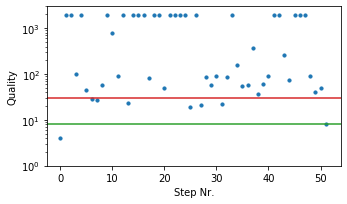

In [3]:
root = tk.Tk()
my_gui = GUI(root)
root.mainloop()
